In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit

# path of bridge data for reading csv file (_roads2)
path     = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab2\infrastructure\_roads3.csv'

# path of bridge data for reading Excel file (BMMS_overview)
bpath     = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab2\infrastructure\BMMS_overview.xlsx'

# Load data file

In [2]:
# reading raw data
df_orig  = pd.read_csv(path,index_col=None, header=0)
bdf_orig = pd.read_excel(bpath, index_col=None, header=0)

# copy dataframe
df = df_orig.copy()
bdf = bdf_orig.copy()

# Display Number of data 
print('')
print('Total Road Data :' ,len(df),'Data')
print('')
print('Total Bridge Data :' ,len(bdf),'Data')


Total Road Data : 51348 Data

Total Bridge Data : 20415 Data


# Select N1 roads that connects Chittagong to Dhaka only

In [3]:
# Create dataframe for N1 roads with filtered longitude and lattitude Bounding box
dfN1  = df_orig[(df_orig['road'] == 'N1') & (df_orig['lat'] < 23.8103) & (df_orig['lon'] < 91.7832)].sort_values(by = 'chainage')
bdfN1 = bdf_orig[(bdf_orig['road'] == 'N1') & (bdf_orig['lat'] < 23.8103) & (bdf_orig['lon'] < 91.7832)].sort_values(by = 'chainage')

print('Total N1 Roads data:',len(dfN1))
print('Total N1 Bridges data:', len(bdfN1))

Total N1 Roads data: 565
Total N1 Bridges data: 271


# Plot the N1 roads and Bridges data

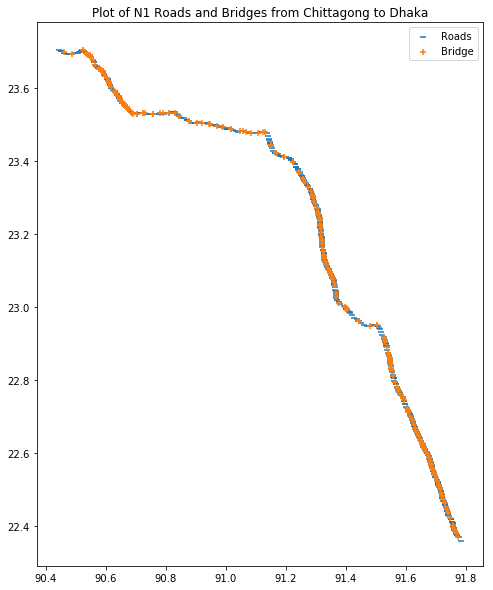

In [4]:
plt.figure(figsize = (8,10))

plt.title('Plot of N1 Roads and Bridges from Chittagong to Dhaka')
plt.scatter(x= dfN1['lon'], y= dfN1['lat'],marker='_',label="Roads")
plt.scatter(x= bdfN1['lon'], y= bdfN1['lat'],marker='+',label="Bridge")
plt.legend()

    We can see from this Graph that the Bridges have the same shape as the roads Therefore the road will be plotted following the shape of the bridges (without vertices).

# Change columns name and create new columns name

In [5]:
#dfN1 = dfN1.rename(index=str, columns={'LRPName': 'lrp','condition':'Quality','length':'Length'})
bdfN1 = bdfN1.rename(index=str, columns={'LRPName': 'lrp','condition':'Quality','length':'Length'})
dfN1['Object Class'] = 'BasicNode'
dfN1['Object Name'] = dfN1['road'] + '_' + dfN1['lrp']

bdfN1['Object Class'] = 'Bridge'
bdfN1['Object Name'] = bdfN1['road'] + '_' + bdfN1['lrp']

bdfN1['Width'] = np.nan
bdfN1['Height'] = np.nan

dfN1['Width'] = np.nan
dfN1['Height'] = np.nan

dfN1['Quality'] = np.nan
dfN1['Length'] = np.nan

# Drop some columns name in roads and bridges dataframe 


    Some of the _roads3 excel files also contains bridges data, therefore it is worth to check whether there are bridges data that might not be recorded in the BMMS excel files.

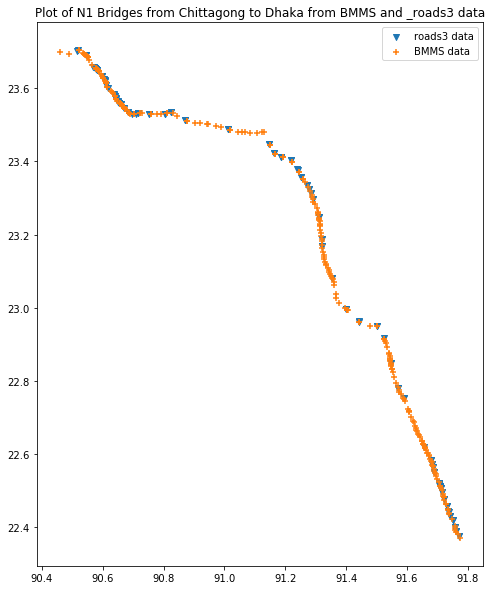

In [6]:
plt.figure(figsize = (8,10))

plt.title('Plot of N1 Bridges from Chittagong to Dhaka from BMMS and _roads3 data')

plt.scatter(x= dfN1[(dfN1['type'] == 'Bridge')]['lon'], y= dfN1[(dfN1['type'] == 'Bridge')]['lat'],marker='v', label="roads3 data")
plt.scatter(x= bdfN1['lon'], y= bdfN1['lat'],marker='+', label="BMMS data")
plt.legend()

    We can see from this Graph that the Bridges from the _roads3 data might not always in the same position as the BMMS data, therefore it is wise to include those bridges from _roads3 data that is not the same (duplicates) as the BMMS bridges into the analysis.


In [7]:
# drop unnecessary column that is not needed in the construction of excel files
dfN1 = dfN1.drop(['gap'], axis=1)
bdfN1 = bdfN1.drop(['km', 'structureNr', 'roadName', 'spans', 'zone','circle','division','sub-division', 
                    'EstimatedLoc','constructionYear','width'], axis=1)

# Match the order of the columns and select only the columns that in roads dataframe to make it easier to combine them
bdfN1 = bdfN1[dfN1.columns]

# Script to convert "Bridges" included in the roads data into bridge data later on
dfN1.loc[(dfN1['type'] == 'Bridge'),'Object Class'] = 'Bridge'
# Assume that those bridges have quality A
dfN1.loc[(dfN1['type'] == 'Bridge'),'Quality'] = 'A'

# Assume that those bridges have the length as the diference in chainage between the chainage of the bridge and its former roads
dfN1['Length'] = (abs(dfN1['chainage'].diff())*1000 ).values

# Script to drop "Bridges" included in the roads data (USE THIS IN CASE WE WANT TO CHANGE THE ASSUMPTION THAT BMMS DATA IS ALREADY PERFECT!!!!)
#dfN1 = dfN1.drop(dfN1[dfN1['type'] == 'Bridge'].index)

# Combine roads and bridges dataframe

In [8]:
# Combined roads and bridges data
df_combined = pd.concat([dfN1, bdfN1]).sort_values(by = 'chainage')

# Drop the duplicates based on LRP name

In [9]:
df_combined = df_combined.drop_duplicates(subset = ['lrp'], keep = 'first', inplace=False)
#df_combined = df_combined.drop_duplicates(subset = ['chainage'],keep = 'first', inplace=False)
df_combined = df_combined.sort_values(by = 'chainage')

# Convert combined dataframe columns name according to xls format

In [10]:
# Create new column name 'Y' with contains 0 values
df_combined['Y'] = 0

# Rename lattitude and longitude name into Z and X
df_combined = df_combined.rename(index=str, columns={'lat': 'Z','lon':'X'})

In [11]:
# Change the order of the dataframe columns name
df_combined = df_combined[['road', 'lrp', 'name','type','chainage','Object Class','Object Name','X','Y','Z','Quality','Length']]

# Convert X and Z coordinates to match Simio coordinates

In [12]:
# Change and scale X and Z coordinates of road
df_combined['X'] = (df_combined['X']-df_combined['X'][0])*1000
df_combined['Z'] = (df_combined['Z']-df_combined['Z'][0])*-1000

# Predefined some Submodel and Objects properties

In [13]:
# Define some empty columns to be fill up later on
df_combined['InterarrivalTime'] = np.nan
df_combined['InitialDesiredSpeed'] = np.nan
df_combined['EntityType'] = np.nan
df_combined['RunInitializedAddOnProcess'] = np.nan
df_combined['EnteredAddOnProcess'] = np.nan

# Define some predefined columns for sub-model bridge
df_combined.loc[(df_combined['Object Class'] == 'Bridge'),'RunInitializedAddOnProcess'] = 'BreakBridgeBasedOnProb'
df_combined.loc[(df_combined['Object Class'] == 'Bridge'),'EnteredAddOnProcess'] = 'SetDelayTime'

# Keep initial and end of rows for the location of source and sink
df_combined.iloc[0, 5] = 'Bridge'
df_combined.iloc[-1, 5] = 'Bridge'

# Sort values
df_combined = df_combined.sort_values(by = 'chainage')

# Create Objectlist dataframe that contained Bridges

In [14]:
df_Objects1  = df_combined[df_combined['Object Class'] == 'Bridge']
df_Objects1 = df_Objects1.reset_index(drop=True)

In [15]:
len(df_Objects1)

216

# Predefined some Objects inside "Objects1" Sheet

In [16]:
df_Objects1.iloc[-1, 5] = 'Source'
df_Objects1.iloc[-1, 6] = 'Chittagong'
df_Objects1.iloc[-1, 11] = np.nan
df_Objects1.iloc[-1, 12] = 5
df_Objects1.iloc[-1, 14] = 'Truck'


df_Objects1.iloc[0, 5] = 'Sink'
df_Objects1.iloc[0, 6] = 'Dhaka'

# Create Links dataframe

In [17]:
# Create vertices sheet (if needed)
# df_vertices1 = pd.DataFrame(index=range(len(df_Objects1)), 
#                       columns=['Link Name','Vertex X', 'Vertex Y','Vertex Z']) 


df_links1 = pd.DataFrame(index=range(len(df_Objects1)), 
                      columns=['Link Class','Link Name','From Node', 'To Node','Network', 'Width', 'Height',
                               'Type','LogicalLength','DrawnToScale'])

In [18]:
# convert chainage into distance for path in simio. This function used the difference between chainage and the units in meter
df_links1['LogicalLength'] = (abs(df_Objects1['chainage'].diff())*1000 ).values

# Predefined properties for path (roads)
df_links1['Link Class'] = 'Path'
df_links1['DrawnToScale'] = 'False'
df_links1['Type'] = 'Unidirectional'

# Filling the connection between node (From Node, To Node) in the excel files
for i in range (len(df_Objects1)-1):
    
    df_links1['Link Name'].iloc[i+1] = (df_Objects1['lrp'][i] + '_' + df_Objects1['lrp'][i+1] + '_' + 'road')
    df_links1['To Node'].iloc[i+1] = (df_Objects1['Object Name'][i])
    df_links1['From Node'].iloc[i+1] = (df_Objects1['Object Name'][i+1])


D:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
# drop the first index (empty)
df_links1 = df_links1.drop(df_links1.index[0])

# Predefined connection between Source to bridge and bridge to Sink
df_links1.iloc[0, 2] = 'N1_LRP001a'
df_links1.iloc[0, 3] = 'Input@Dhaka'
df_links1.iloc[-1, 2] = 'Output@Chittagong'
df_links1.iloc[-1, 3] = 'N1_LRP234a'

# Drop some columns name to match the xls format for simio

In [20]:
df_Objects1 = df_Objects1.drop(['road', 'lrp', 'name', 'type', 'chainage'], axis=1)

# Create dummy dataframe to insert predefined "Entity" inside dataframe

In [21]:
df_dummy = pd.DataFrame( index = range(1),
                       columns=df_Objects1.columns.values)

df_dummy.iloc[0, 0] = 'ModelEntity'
df_dummy.iloc[0, 1] = 'Truck'
df_dummy.iloc[0, 2] = 0
df_dummy.iloc[0, 3] = 0
df_dummy.iloc[0, 4] = 4
df_dummy.iloc[0, 8] = 13.33

In [22]:
# Insert the entity into the Objects dataframe
df_Objects1 = pd.concat([df_Objects1, df_dummy])

# *Bonus Assignment time

In [23]:
df_Objects1[df_Objects1['Length'] > 200].sort_values(by = 'Quality',ascending=False).head(5)

,Object Class,Object Name,X,Y,Z,Quality,Length,InterarrivalTime,InitialDesiredSpeed,EntityType,RunInitializedAddOnProcess,EnteredAddOnProcess
65,Bridge,N1_LRP037a,259.107,0,175.643,C,1408.8,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
148,Bridge,N1_LRP166a,1082.96,0,791.063,B,220.6,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
33,Bridge,N1_LRP023a,166.218,0,88.387,B,214.09,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
34,Bridge,N1_LRP023b,166.218,0,88.387,B,224.82,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
4,Bridge,N1_LRP008b,75.4997,0,1.4445,A,418,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime


In [24]:
df_Objects1[df_Objects1['Length'] > 200].sort_values(by = 'Length',ascending=False).head(4)

,Object Class,Object Name,X,Y,Z,Quality,Length,InterarrivalTime,InitialDesiredSpeed,EntityType,RunInitializedAddOnProcess,EnteredAddOnProcess
65,Bridge,N1_LRP037a,259.107,0,175.643,C,1408.8,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
159,Bridge,N1_LRP183a,1126.19,0,924.695,A,994,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
71,Bridge,N1_LRP042a,308.084,0,176.64,A,967,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime
183,Bridge,N1_LRP216a,1262.03,0,1186.61,A,957,NaN,NaN,NaN,BreakBridgeBasedOnProb,SetDelayTime


Based on this, we can assume that N1_LRP037a, N1_LRP166a, N1_LRP023a, N1_LRP023b and N1_LRP183a could be optimized since these bridges have quite a High Length (top 5) with not so great condition (quality lower than A), for later on we tried to simulate in the Simio model for these bridges behaviour.

# Preparing the Objectlists sheet columns order and its predefine columns

In [25]:
# Predefined columns height, width, length
df_Objects1 = df_Objects1.rename(index=str, columns={'Length': 'Length_2'})
df_Objects1['Length'] = np.nan
df_Objects1['Width'] = np.nan
df_Objects1['Height'] = np.nan

In [26]:
# Ordering the dataframe for the excel files
df_Objects1 = df_Objects1[['Object Class', 'Object Name', 'X', 'Y', 'Z','Length', 'Width',
       'Height','InterarrivalTime', 'InitialDesiredSpeed', 'EntityType',
       'RunInitializedAddOnProcess', 'EnteredAddOnProcess', 'Quality', 'Length_2']]
df_Objects1 = df_Objects1.rename(index=str, columns={'Length_2': 'Length'})

# Convert dataframe into excel 

In [27]:
writer = pd.ExcelWriter('output.xlsx')
# First sheet
df_Objects1.to_excel(writer,'Objects1',index = False)
# Second sheet
df_links1.to_excel(writer,'Links1',index = False)
writer.save()